In [31]:
import pandas as pd
data = pd.read_csv(r"contact_history_multiple.csv", encoding="utf-8", sep=";")


In [33]:


# Convert the 'EVENT.DATE' column to datetime format
data['EventDate'] = pd.to_datetime(data['EventDate'], format='%Y-%m-%d %H:%M:%S')

# Add a column for the day of the week
data['day_of_week'] = data['EventDate'].dt.day_name()

# Display the first few rows
#print(data.head())


In [35]:
import math
'''So here we convert the set time into minutes and the other way around and we calculate the time spent for receiving or engaging compared to the hour range''' 
def sent_date_to_min(sent_time):
    ''' Given the sent datetime, return the total minutes since midnight. '''
    return sent_time.hour * 60 + sent_time.minute

def from_min_to_hour_and_min(mins):
    '''Given the total minutes, return a formatted string representing hours and minutes.'''
    hours = int(round(mins)) // 60
    minutes = int(round(mins)) % 60
    return "{}:{}".format(hours, minutes)

def exp_decay_fit(x, sent_engaged_hour_range):
    '''Return a value from 0 to 1 following an exponential decreasing function.
       This represents the probability of engagement decreasing over time.'''
    if x > sent_engaged_hour_range * 60:
        return 0.0  # If engagement is beyond the defined time range, probability is zero
    if x < 0:
        return 1  # If engagement is instant, probability is highest
    return math.exp(15 * ((-math.log(2) / (sent_engaged_hour_range * 60)) * x) + math.log(2)) / 2
print (sent_date_to_min(data["EventDate"][0]))
print (exp_decay_fit(10,5))

697
0.7071067811865475


In [39]:
import pandas as pd
import math
''' here we get all the indexes of the rows if a certain contact and message then we calculate the time of the first action which is always revieved
how much it took time by calculating the actions - the sent time and then it's decay compared to the hourRange'''
def get_all_indexes(hash_mex, hash_contact, data):
    list_index = []
    for i in range(len(data)):  # Corrected range syntax
        if data['HashMessage'].iloc[i] == hash_mex and data['HashContact'].iloc[i] == hash_contact:
            list_index.append(i)
    return list_index

def compute_fitSA(hash_mex, hash_contact, sent_engage_hour_range, data):
    '''Given the hash message, the hash contact, and the dataset, return the fitSA 
    for that hash message and hash contact in an SMS campaign.'''
    '''we create 2 arrays'''
    sents, received = [], []
    list_index = get_all_indexes(hash_mex, hash_contact, data) 
    '''array contains all the indexes of the hashmessage and hashcontact'''
    
    for i in list_index:
        ''' thot row mtaa el index i (date w name) f des varibales bech tekhdem behom baed ala hasb valeur mtaa les varibales 
        baed thothom f wahda mel arrays  , sents reveived w engaged'''
        event_type = data['EventName'].iloc[i]  # Use .iloc[i] for proper indexing
        event_time = data["EventDate"].iloc[i]
        
        if event_type == 'Sent':
            sents.append(event_time)
        elif event_type == 'Received':
            received.append(event_time)
    
    if not sents:
        return 0.0, None  # Safeguard: There must be a 'Sent' event
    
    sent_time = sent_date_to_min(sents[0])  # Convert sent time to minutes
    
    # Find the earliest event after 'Sent': first Received, then Engaged
    first_event = None
    if received:
        first_event = min(received)  # First time the SMS was received
    '''tekhou awel event''' 
    
    # If no engagement happens, return 0
    if first_event is None:
        return 0.0, sent_time  
    
    # Compute the time difference between Sent and First Engagement
    mins = (first_event - sents[0]).total_seconds() / 60  # Convert to minutes

    return exp_decay_fit(mins, sent_engage_hour_range), sent_time

# Example usage
print(compute_fitSA("msg9968", "contact1161", 5, data))


(0.2679433656340733, 1086)


In [43]:
''' here it's the same but we're calculating the difference between the received and engaged'''
def compute_fitAC(hash_mex, hash_contact, received_engaged_hour_range, data):
    '''Given the hash message, the hash contact, and the dataset, return the fitAC
    for that hash message and hash contact in an SMS campaign.'''

    received, engaged = [], []

    list_index = get_all_indexes(hash_mex, hash_contact, data)
    
    for i in list_index:
        event_type = data['EventName'].iloc[i]  # Correct indexing
        event_time = data["EventDate"].iloc[i]

        if event_type == 'Received':
            received.append(event_time)
        elif event_type == 'Engaged':
            engaged.append(event_time)
    
    oldest_received = None
    oldest_engaged = None

    # Case: Message engaged but "Received" event not detected
    if not received and engaged:
        return -1  

    # Case: No engagement at all
    if not engaged:
        return 0.0  
    
    # Find the first Received and first Engaged event
    if received:
        oldest_received = min(received)
    if engaged:
        oldest_engaged = min(engaged)

    # Compute time difference in minutes between Received and Engaged
    mins = (oldest_engaged - oldest_received).total_seconds() / 60  
    return exp_decay_fit(mins, received_engaged_hour_range)
print(compute_fitAC("msg9968", "contact1161", 5, data))


0.7320428479728127


In [45]:
pip install matplotlib

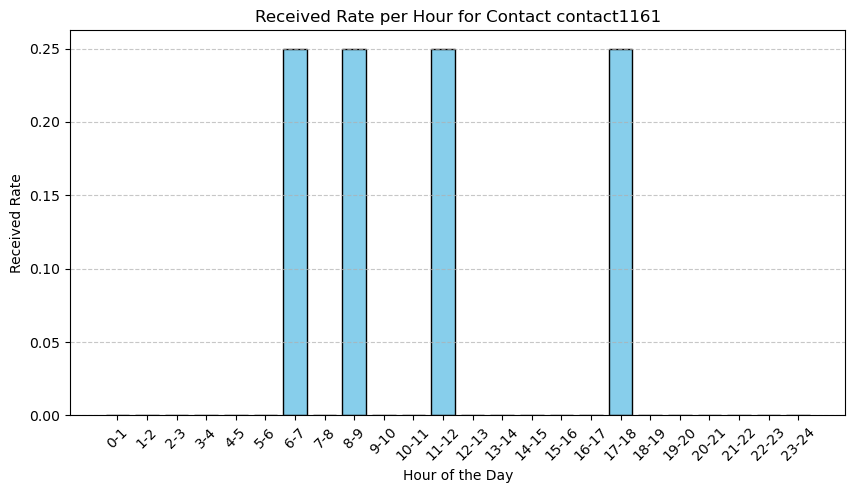

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def received_rate_mex_time_slot(hash_contact, data):
    '''Given a hash contact and the dataset, return the received rate for that contact in each
    hour (from 0 to 24).'''
    mex_plus_contact_distinct = []
    dates = []
    list_index = get_all_indexes_contact(hash_contact, data)
    
    for i in list_index:
        if pd.notna(data["EventDate"][i]) and str(data["EventName"][i]) == 'Received' \
           and (data["HashMessage"][i] + data['HashContact'][i]) not in mex_plus_contact_distinct:
            mex_plus_contact_distinct.append(data["HashMessage"][i] + data['HashContact'][i])
            dates.append(data["EventDate"][i])
    
    tot_mex_received = len(mex_plus_contact_distinct)
    if len(dates) == 0:  # If the user has never received messages
        return np.zeros((24,))
    
    df = pd.DataFrame(dates, columns=['dates'])
    df = df.assign(session=pd.cut(df["dates"].dt.hour,
                                  bins=list(range(25)),
                                  labels=[f'{i}-{i+1}' for i in range(24)],
                                  include_lowest=True))
    
    numpy_output = df['session'].value_counts().sort_index().to_numpy() / tot_mex_received
    return numpy_output, df['session'].value_counts().sort_index().index

def get_all_indexes_contact(hash_contact, data):
    '''Given a hash contact and the dataset, return all indexes where this contact appears.'''
    list_index = []
    for i in range(len(data)):
        if data['HashContact'][i] == hash_contact:
            list_index.append(i)
    return list_index


# Compute received rates
hash_contact = "contact1161"  # Change this for different contacts
received_rates, time_slots = received_rate_mex_time_slot(hash_contact, data)

# Plotting the brick diagram (bar chart)
plt.figure(figsize=(10, 5))
plt.bar(time_slots, received_rates, color='skyblue', edgecolor='black')

plt.xlabel("Hour of the Day")
plt.ylabel("Received Rate")
plt.title(f"Received Rate per Hour for Contact {hash_contact}")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


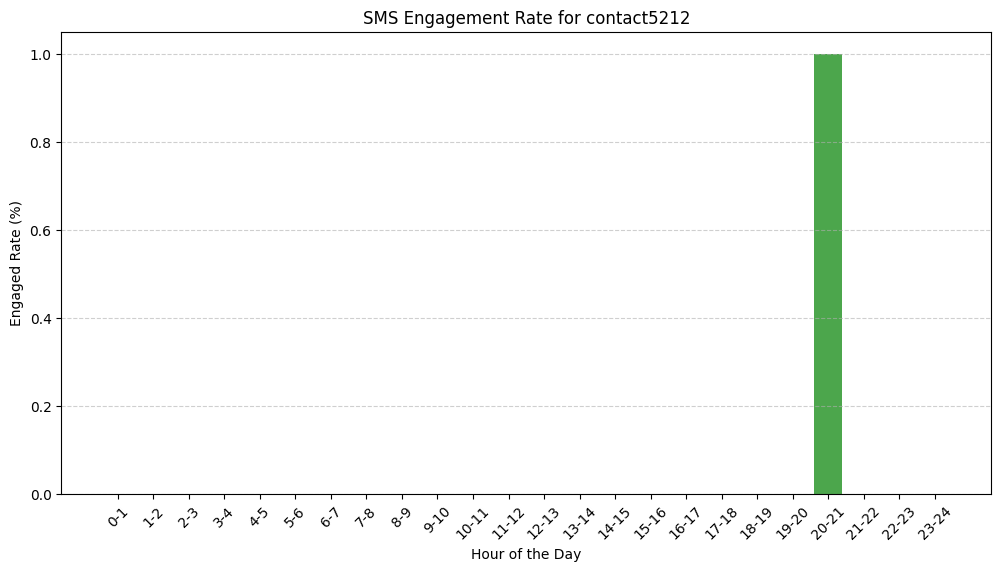

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def engaged_rate_mex_time_slot(hash_contact, data):
    '''Given a hash contact and the dataset, return the engagement rate Engaged for that contact in each hour (0-24).'''
    
    mex_plus_contact_distinct = []
    dates = []
    list_index = get_all_indexes_contact(hash_contact, data)
    
    for i in list_index:
        if pd.notna(data["EventDate"][i]) and str(data["EventName"][i]) in 'Engaged' \
           and (data["HashMessage"][i] + data['HashContact'][i]) not in mex_plus_contact_distinct:
            mex_plus_contact_distinct.append(data["HashMessage"][i] + data['HashContact'][i])
            dates.append(data["EventDate"][i])
    
    tot_mex_engaged = len(mex_plus_contact_distinct)
    if len(dates) == 0:  # If the user has never engaged
        return np.zeros((24,)), [f'{i}-{i+1}' for i in range(24)]
    
    df = pd.DataFrame(dates, columns=['dates'])
    df = df.assign(session=pd.cut(df["dates"].dt.hour,
                                  bins=list(range(25)),
                                  labels=[f'{i}-{i+1}' for i in range(24)],
                                  include_lowest=True))
    
    numpy_output = df['session'].value_counts().sort_index().to_numpy() / tot_mex_engaged
    return numpy_output, df['session'].value_counts().sort_index().index

def plot_engaged_rate(hash_contact, data):
    '''Plots a brick-style bar graph for the engagement rate per hour for a given contact.'''
    
    engaged_rate, engaged_labels = engaged_rate_mex_time_slot(hash_contact, data)
    
    plt.figure(figsize=(12, 6))
    plt.bar(engaged_labels, engaged_rate, color='green', alpha=0.7)
    
    plt.xlabel("Hour of the Day")
    plt.ylabel("Engaged Rate (%)")
    plt.title(f"SMS Engagement Rate for {hash_contact}")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    
    plt.show()
plot_engaged_rate("contact5212", data)



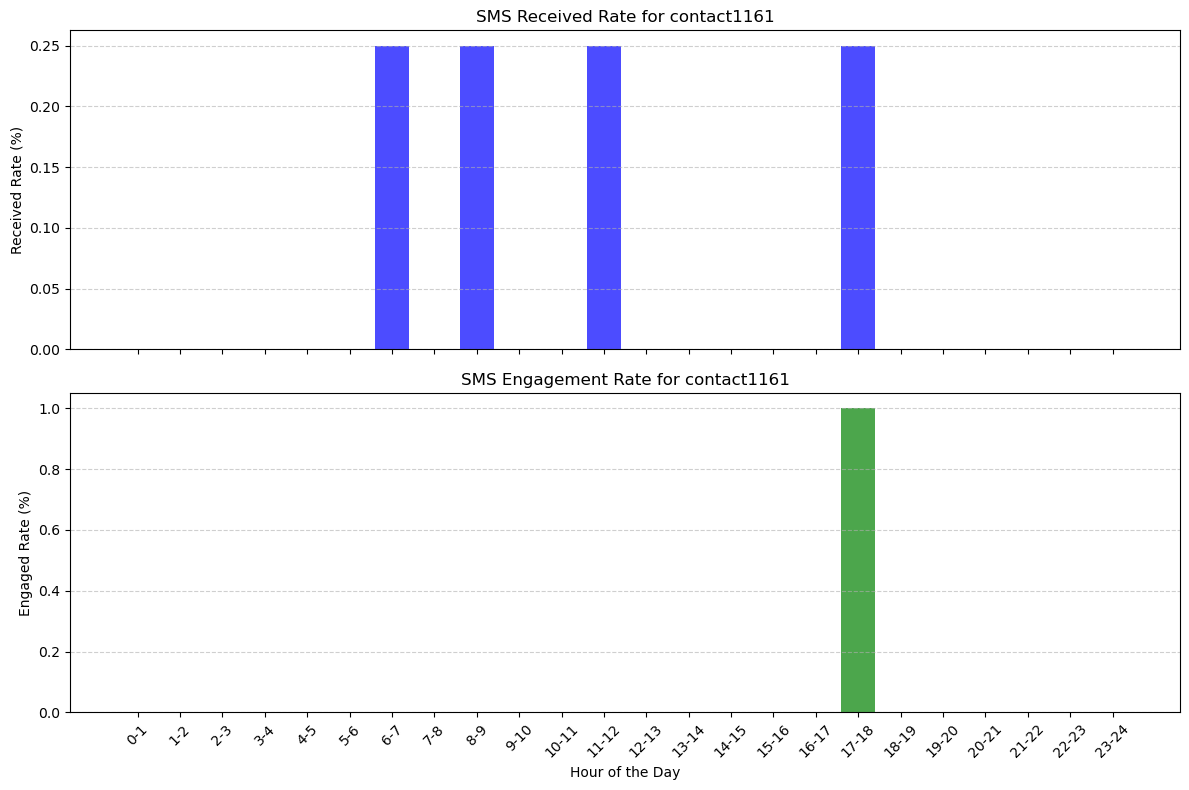

In [49]:
def plot_received_and_engaged_rate(hash_contact, data):
    '''Plots two brick graphs comparing the received and engaged SMS rates for a given contact.'''
    
    received_rate, received_labels = received_rate_mex_time_slot(hash_contact, data)
    engaged_rate, engaged_labels = engaged_rate_mex_time_slot(hash_contact, data)
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # Plot Received Rate
    axes[0].bar(received_labels, received_rate, color='blue', alpha=0.7)
    axes[0].set_ylabel("Received Rate (%)")
    axes[0].set_title(f"SMS Received Rate for {hash_contact}")
    axes[0].grid(axis='y', linestyle='--', alpha=0.6)
    
    # Plot Engaged Rate
    axes[1].bar(engaged_labels, engaged_rate, color='green', alpha=0.7)
    axes[1].set_ylabel("Engaged Rate (%)")
    axes[1].set_title(f"SMS Engagement Rate for {hash_contact}")
    axes[1].grid(axis='y', linestyle='--', alpha=0.6)
    
    plt.xticks(rotation=45)
    plt.xlabel("Hour of the Day")
    plt.tight_layout()
    plt.show()
plot_received_and_engaged_rate("contact1161", data)


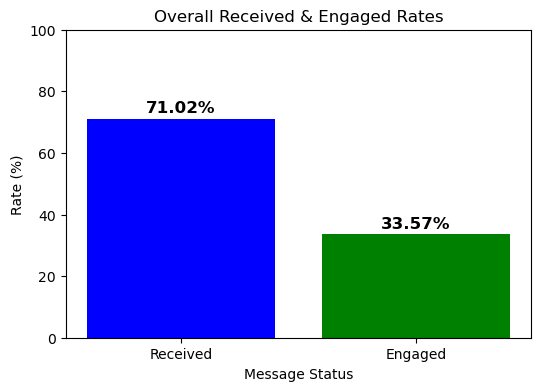

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def overall_received_and_engaged_rates(data):
    '''Calculates and visualizes the overall received and engaged rates compared to sent messages for the entire dataset.'''

    sent_count = sum(1 for i in range(len(data)) if data["EventName"][i] == "Sent")
    received_count = sum(1 for i in range(len(data)) if data["EventName"][i] == "Received")
    engaged_count = sum(1 for i in range(len(data)) if data["EventName"][i] == "Engaged")  # Corrected!

    if sent_count == 0:  # Avoid division by zero
        print("No messages were sent in the dataset.")
        return

    received_rate = (received_count / sent_count) * 100
    engaged_rate = (engaged_count / sent_count) * 100

    #  Creating the bar chart
    categories = ["Received", "Engaged"]
    values = [received_rate, engaged_rate]

    plt.figure(figsize=(6, 4))
    plt.bar(categories, values, color=['blue', 'green'])
    
    plt.ylim(0, 100)  # Limits to 100% since we’re dealing with percentages
    plt.xlabel("Message Status")
    plt.ylabel("Rate (%)")
    plt.title("Overall Received & Engaged Rates")

    # Adding value labels on top of the bars
    for i, v in enumerate(values):
        plt.text(i, v + 2, f"{v:.2f}%", ha='center', fontsize=12, fontweight='bold')

    plt.show()

    return received_rate, engaged_rate
received_rate, engaged_rate = overall_received_and_engaged_rates(data)


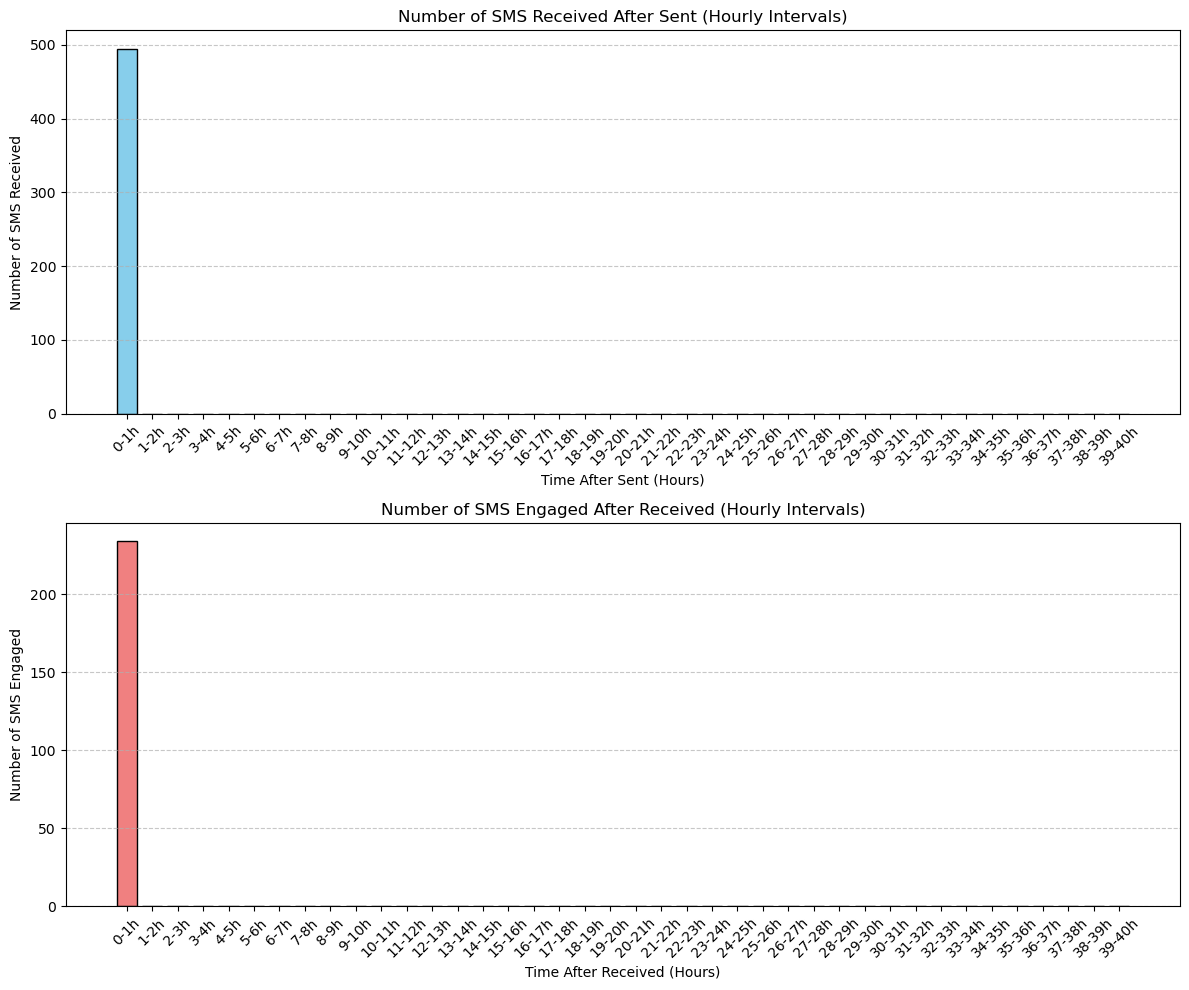

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter data based on event types
sent_data = data[data["EventName"] == "Sent"]
received_data = data[data["EventName"] == "Received"]
engaged_data = data[data["EventName"] == "Engaged"]

# Merge sent and received data to track received delays
merged_sent_received = sent_data.merge(received_data, on=["HashMessage", "HashContact"], suffixes=('_sent', '_received'))
merged_sent_received["DelayHours"] = (merged_sent_received["EventDate_received"] - merged_sent_received["EventDate_sent"]).dt.total_seconds() / 3600

# Merge received and engaged data to track engagement delays
merged_received_engaged = received_data.merge(engaged_data, on=["HashMessage", "HashContact"], suffixes=('_received', '_engaged'))
merged_received_engaged["DelayHours"] = (merged_received_engaged["EventDate_engaged"] - merged_received_engaged["EventDate_received"]).dt.total_seconds() / 3600

# Define bins (1-hour intervals up to 40 hours)
bins = list(range(41))  # 0 to 40 hours

# Process Sent → Received delays
merged_sent_received["DelayBin"] = pd.cut(merged_sent_received["DelayHours"], bins=bins, labels=[f"{i}-{i+1}h" for i in range(40)], include_lowest=True)
delay_distribution_sent_received = merged_sent_received["DelayBin"].value_counts().sort_index()

# Process Received → Engaged delays
merged_received_engaged["DelayBin"] = pd.cut(merged_received_engaged["DelayHours"], bins=bins, labels=[f"{i}-{i+1}h" for i in range(40)], include_lowest=True)
delay_distribution_received_engaged = merged_received_engaged["DelayBin"].value_counts().sort_index()

# Plot both histograms
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot Sent → Received delay
axes[0].bar(delay_distribution_sent_received.index, delay_distribution_sent_received.values, color="skyblue", edgecolor="black")
axes[0].set_title("Number of SMS Received After Sent (Hourly Intervals)")
axes[0].set_xlabel("Time After Sent (Hours)")
axes[0].set_ylabel("Number of SMS Received")
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot Received → Engaged delay
axes[1].bar(delay_distribution_received_engaged.index, delay_distribution_received_engaged.values, color="lightcoral", edgecolor="black")
axes[1].set_title("Number of SMS Engaged After Received (Hourly Intervals)")
axes[1].set_xlabel("Time After Received (Hours)")
axes[1].set_ylabel("Number of SMS Engaged")
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


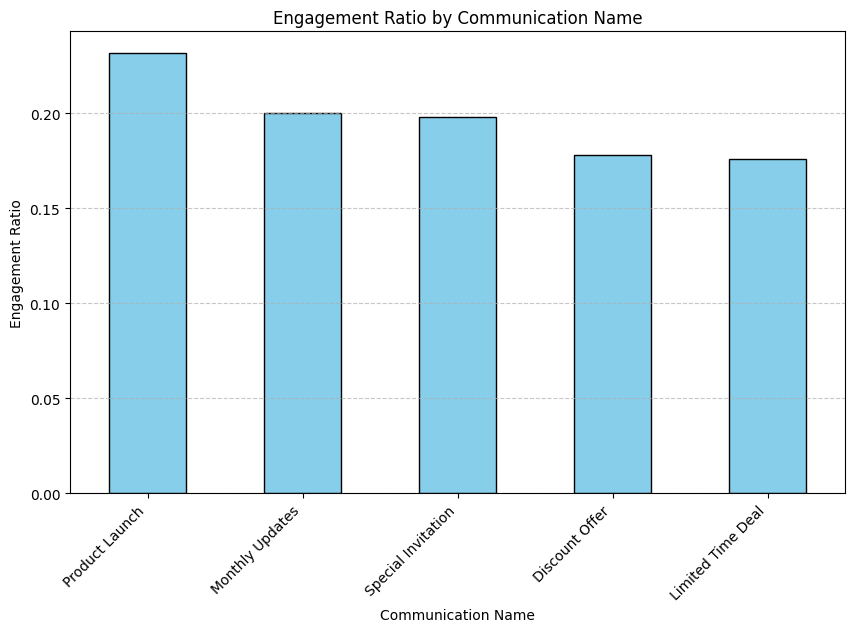

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

def engagement_by_communication(data):
    """
    Calculates and visualizes the engagement ratio (Open & Click) for each CommunicationName.
    """
    # Count Sent messages per CommunicationName
    sent_counts = data[data['EventName'] == 'Sent'].groupby('CommunicationName').size()
    
    # Count Engaged messages per CommunicationName
    engaged_counts = data[data['EventName'] == 'Engaged'].groupby('CommunicationName').size()

    # Calculate engagement ratio (avoid division by zero)
    engagement_ratio = (engaged_counts / sent_counts).fillna(0)

    # Plot the engagement ratio
    plt.figure(figsize=(10, 6))
    engagement_ratio.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')

    # Customize plot
    plt.title('Engagement Ratio by Communication Name')
    plt.xlabel('Communication Name')
    plt.ylabel('Engagement Ratio')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.show()

# Example usage:
# data = pd.read_csv("your_dataset.csv", parse_dates=["EventDate"])
engagement_by_communication(data)


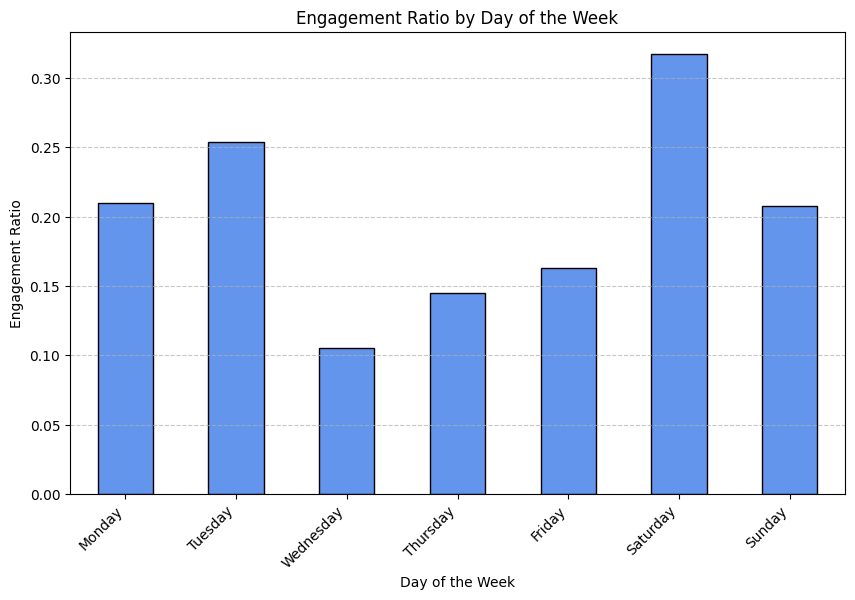

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

def engagement_by_day_of_week(data):
    """
    Calculates and visualizes the engagement ratio (Engaged/Sent) for each day of the week.
    """
    # Convert EventDate to datetime
    data["EventDate"] = pd.to_datetime(data["EventDate"])
    
    # Extract day of the week
    data["DayOfWeek"] = data["EventDate"].dt.day_name()

    # Count Sent and Engaged messages per day of the week
    sent_counts = data[data["EventName"] == "Sent"].groupby("DayOfWeek").size()
    engaged_counts = data[data["EventName"] == "Engaged"].groupby("DayOfWeek").size()

    # Calculate engagement ratio (Engaged/Sent), avoid division by zero
    engagement_ratio = (engaged_counts / sent_counts).fillna(0)

    # Order days of the week
    day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    engagement_ratio = engagement_ratio.reindex(day_order)

    # Plot the engagement ratio
    plt.figure(figsize=(10, 6))
    engagement_ratio.plot(kind="bar", color="cornflowerblue", edgecolor="black")

    # Customize plot
    plt.title("Engagement Ratio by Day of the Week")
    plt.xlabel("Day of the Week")
    plt.ylabel("Engagement Ratio")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Show the plot
    plt.show()

# Example usage:
# data = pd.read_csv("your_dataset.csv", parse_dates=["EventDate"])
engagement_by_day_of_week(data)


In [55]:
import pandas as pd
import math

def exp_decay_fit(x, sent_engaged_hour_range):
    '''Return a value from 0 to 1 following an exponential decreasing function.
       This represents the probability of engagement decreasing over time.'''
    if x > sent_engaged_hour_range * 60:
        return 0.0  # If engagement is beyond the defined time range, probability is zero
    if x < 0:
        return 1.0  # If engagement is instant, probability is highest
    return math.exp(15 * ((-math.log(2) / (sent_engaged_hour_range * 60)) * x) + math.log(2)) / 2

def compute_sms_fitSA(hash_msg, hash_contact, sent_engaged_hour_range, data, sent_pred):
    """
    Computes the SMS fitness score based on how quickly it was received or engaged.
    
    Parameters:
        hash_msg (str): Unique identifier of the message.
        hash_contact (str): Unique identifier of the contact.
        sent_engaged_hour_range (float): The max time window (in hours) before fitness decays to 0.
        data (pd.DataFrame): The dataset containing SMS events.
        sent_pred (str): Sent time in HH:MM format.

    Returns:
        float: The fitness score in range [0,1].
    """
    # Convert sent_pred to datetime format
    sent_pred = pd.to_datetime(sent_pred, format='%Y-%m-%d %H:%M:%S')

    # Filter data for the given message and contact
    df2 = data[data['HashMessage'] == hash_msg]
    df3 = df2[df2['HashContact'] == hash_contact]
    
    # Get 'Received' event
    df4 = df3[df3['EventName'] == 'Received']
    received_times = list(df4['EventDate'])
    print(received_times)
    # Get 'Engaged' event (if available)
    df5 = df3[df3['EventName'] == 'Engaged']
    engaged_times = list(df5['EventDate'])
    print(engaged_times)

    # Find the earliest event (received or engaged)
    earliest_event = None
    for time in received_times + engaged_times:
        if earliest_event is None or time < earliest_event:
            earliest_event = time
    print(earliest_event)
    print(sent_pred)
    # If the SMS was never received or engaged, return 0
    if earliest_event is None:
        return 0.0
    if earliest_event < sent_pred :
        print("sent can't be after receive or enagaged")
        return 0.0
    # Compute minutes elapsed from sent time to first interaction
    minutes_elapsed = (earliest_event - sent_pred).total_seconds() / 60
    print(minutes_elapsed)
    # Compute fitness score using the provided exponential decay function
    return exp_decay_fit(minutes_elapsed, sent_engaged_hour_range)


# Test function
fitness_score = compute_sms_fitSA("msg5435", "contact5212", sent_engaged_hour_range=5, data=data, sent_pred="2025-01-07 22:00:00")
print("Fitness Score:", fitness_score)


def compute_sms_fitAC(hash_msg, hash_contact, sent_engaged_hour_range, data, sent_pred):
    """
    Computes the SMS fitness score based on how quickly it was received or engaged.
    
    Parameters:
        hash_msg (str): Unique identifier of the message.
        hash_contact (str): Unique identifier of the contact.
        sent_engaged_hour_range (float): The max time window (in hours) before fitness decays to 0.
        data (pd.DataFrame): The dataset containing SMS events.
        sent_pred (str): Sent time in HH:MM format.

    Returns:
        float: The fitness score in range [0,1].
    """
    # Convert sent_pred to datetime format
    sent_pred = pd.to_datetime(sent_pred, format='%Y-%m-%d %H:%M:%S')

    # Filter data for the given message and contact
    df2 = data[data['HashMessage'] == hash_msg]
    df3 = df2[df2['HashContact'] == hash_contact]
    df5 = df3[df3['EventName'] == 'Engaged']
    engaged_times = list(df5['EventDate'])
    print(engaged_times)

    # Find the earliest event (received or engaged)
    earliest_event = None
    for time in engaged_times:
        if earliest_event is None or time < earliest_event:
            earliest_event = time
    print(earliest_event)
    print(sent_pred)
    # If the SMS was never received or engaged, return 0
    if earliest_event is None:
        return 0.0
    if earliest_event < sent_pred :
        print("sent can't be after receive or enagaged")
        return 0.0

    # Compute minutes elapsed from sent time to first interaction
    minutes_elapsed = (earliest_event - sent_pred).total_seconds() / 60
    print(minutes_elapsed)
    # Compute fitness score using the provided exponential decay function
    return exp_decay_fit(minutes_elapsed, sent_engaged_hour_range)
fitness_score = compute_sms_fitAC("msg5435", "contact5212", sent_engaged_hour_range=5, data=data, sent_pred="2025-01-07 22:00:00")
print("Fitness Score:", fitness_score)

[]
[]
None
2025-01-07 22:00:00
Fitness Score: 0.0
[]
None
2025-01-07 22:00:00
Fitness Score: 0.0
